In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
import hdf5storage
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D  
from tensorflow.keras.layers import MaxPooling1D 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from keras.models import Model
from sklearn.feature_selection import VarianceThreshold


## 1. Data Read

In [2]:
LOB_input = hdf5storage.loadmat('S092215-v50-AMZN_OCT2_states.mat')
LOB_Amazon = pd.DataFrame.from_dict(LOB_input['LOB'])

## 2. Data Pre-processing

- Add titles for columns
- Convert Time column to a readable time format
- Remove unreliable columns
- Remove missing values
- Filter data for standard trading time (between 9:30:000000 and 16:00:000000)

In [3]:
# Add Column Titles
LOB_Amazon.columns = [
                      "Time", "Mid_Price", "Spread", 
                      "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1", # Level 1
                      "AskPrice2", "AskVolume2","BidPrice2", "BidVolume2", # Level 2
                      "AskPrice3", "AskVolume3","BidPrice3", "BidVolume3", # Level 3
                      "AskPrice4", "AskVolume4","BidPrice4", "BidVolume4", # Level 4
                      "AskPrice5", "AskVolume5","BidPrice5", "BidVolume5", # Level 5
                      "AskPrice6", "AskVolume6","BidPrice6", "BidVolume6", # Level 6
                      "AskPrice7", "AskVolume7","BidPrice7", "BidVolume7", # Level 7
                      "AskPrice8", "AskVolume8","BidPrice8", "BidVolume8", # Level 8
                      "AskPrice9", "AskVolume9","BidPrice9", "BidVolume9", # Level 9
                      "AskPrice10", "AskVolume10","BidPrice10", "BidVolume10", # Level 10
                     ]
import datetime
    
# Version 1.0
new_time_column = []
for item in LOB_Amazon["Time"]:
    current_row = datetime.datetime.fromtimestamp(item/1000.0) #1000.0 since 1 sec = 1000 mls
    new_time_column.append(current_row)

# Version 2.0
readable_time = []
for i in range(0,len(new_time_column)):
    current_time = new_time_column[i].strftime("%H:%M:%f")
    readable_time.append(current_time)   
LOB_Amazon['Time'] = readable_time

In [4]:
LOB_Amazon.head()

,Time,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,...,BidPrice8,BidVolume8,AskPrice9,AskVolume9,BidPrice9,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10
0,05:00:000000,0,0,0,0,5427400,100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,05:00:000000,5452100,49400,5476800,100,5427400,100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,05:00:073000,5451900,49000,5476400,100,5427400,100,5476800,100,0,...,0,0,0,0,0,0,0,0,0,0
3,05:00:073000,5452000,48800,5476400,100,5427600,100,5476800,100,5427400,...,0,0,0,0,0,0,0,0,0,0
4,05:00:073000,5452000,48800,5476400,100,5427600,100,5476800,100,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# I consider variables with over 30% missing values unreliable, so delete them from the data
df = LOB_Amazon.copy()
size = len(df)

problems = df.isnull().any(axis=1)

for col in df.columns:
    perc = df[col].isnull().sum() / float(size)
    if perc > 0.3:
        print('Deleting column {0}: missing perc={1:.2f}'.format(col, perc))    
        df = df.drop([col], axis=1)
        if col in df.columns: 
            df.columns.remove(col)
            
problems = df.isnull().any(axis=1)

print("All rows: ", size)
print("Rows with missing values: {0}".format(problems.sum()))

All rows:  562650
Rows with missing values: 0


In [6]:
# Remove rows with missing values (NaN, value = 0, inf)

missing = df.iloc[:, 1:].isnull() | (df.iloc[:, 1:] == 0) | np.isinf(df.iloc[:, 1:])
df = df[~missing.any(axis=1)]

#Locate the index of observation ranges between 9:30 and 16:00

df_filtered = df[(df['Time'] >= '09:30:00') & (df['Time'] <= '16:00:00')]
print(f"Trading time range index: from {df.index.min()} to {df.index.max()}")


Trading time range index: from 85158 to 562595


## 3. Data Description

- Plot histogram of Mid Price
- Plot Time Series for Mid price and Spread

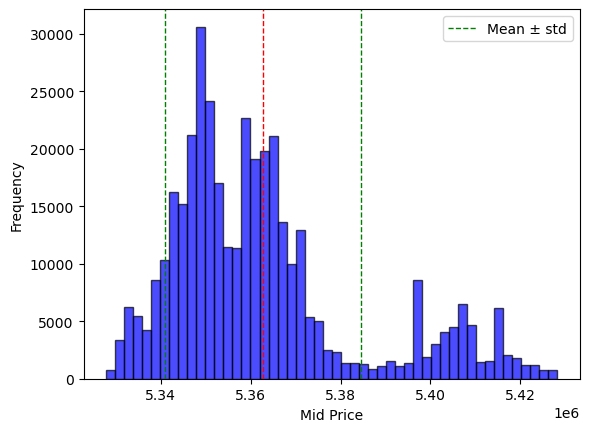

In [7]:
# Plot histogram of Mid Price

mean_mid_price = df_filtered['Mid_Price'].mean()
std_mid_price = df_filtered['Mid_Price'].std()

# Choose 3 standard deviations from the mean
lower_bound = mean_mid_price - 3 * std_mid_price
upper_bound = mean_mid_price + 3 * std_mid_price

# Filter the data to include only values within the bounds
filtered_mid_prices = df_filtered['Mid_Price'][(df_filtered['Mid_Price'] >= lower_bound) & (df_filtered['Mid_Price'] <= upper_bound)]

plt.hist(filtered_mid_prices, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(mean_mid_price, color='red', linestyle='dashed', linewidth=1)
plt.axvline(mean_mid_price + std_mid_price, color='green', linestyle='dashed', linewidth=1, label='Mean ± std')
plt.axvline(mean_mid_price - std_mid_price, color='green', linestyle='dashed', linewidth=1)
plt.xlabel('Mid Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


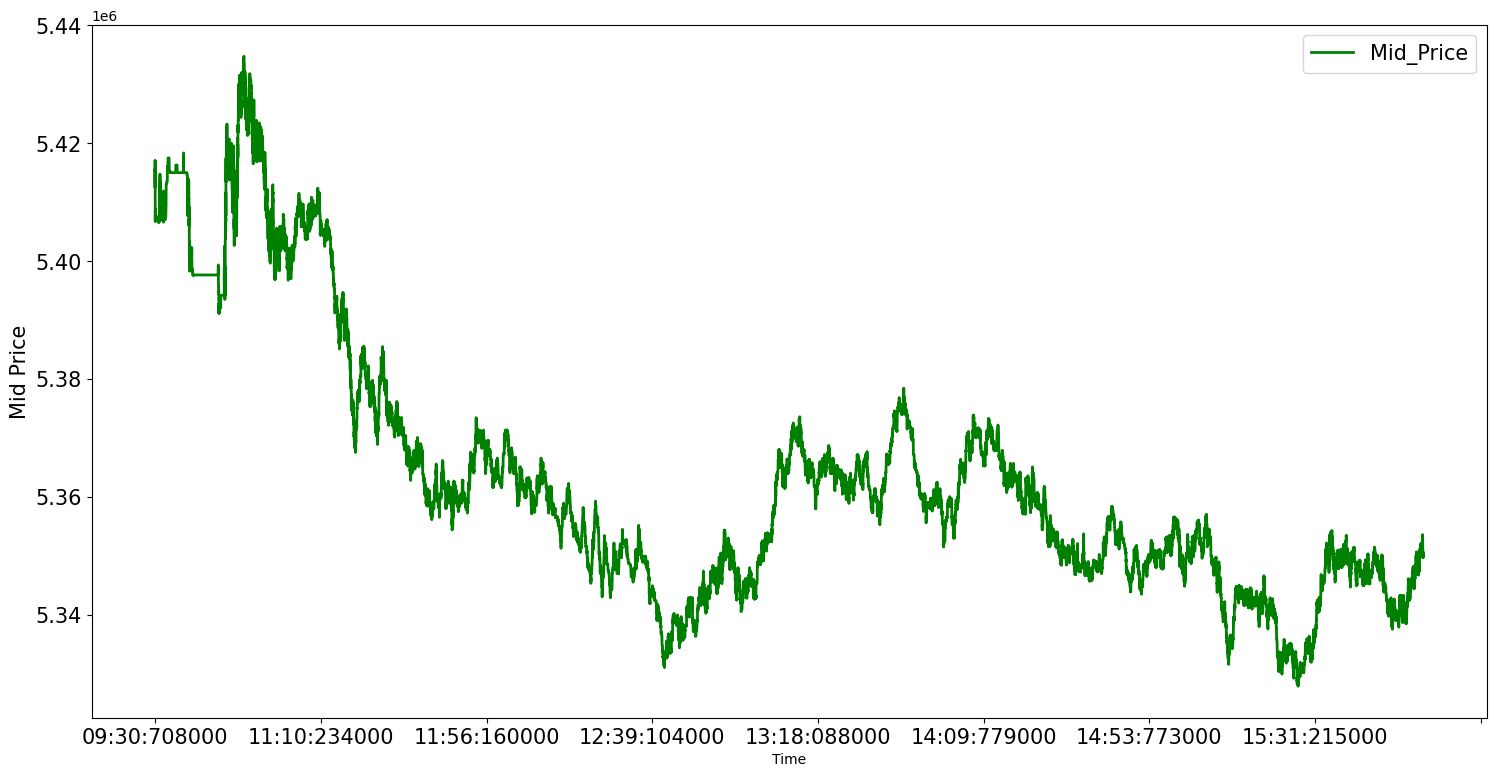

In [8]:
# Plot time series for Mid Price

df_filtered.plot(x="Time",
                  y=["Mid_Price"], figsize=(18, 9), linewidth=2.0, 
                       color = {"green"}, 
                       fontsize=15
                      )
plt.legend(loc=1, prop={'size': 15})
plt.rcParams.update({'font.size': 15})
plt.ylabel('Mid Price',fontsize=15)
plt.show()

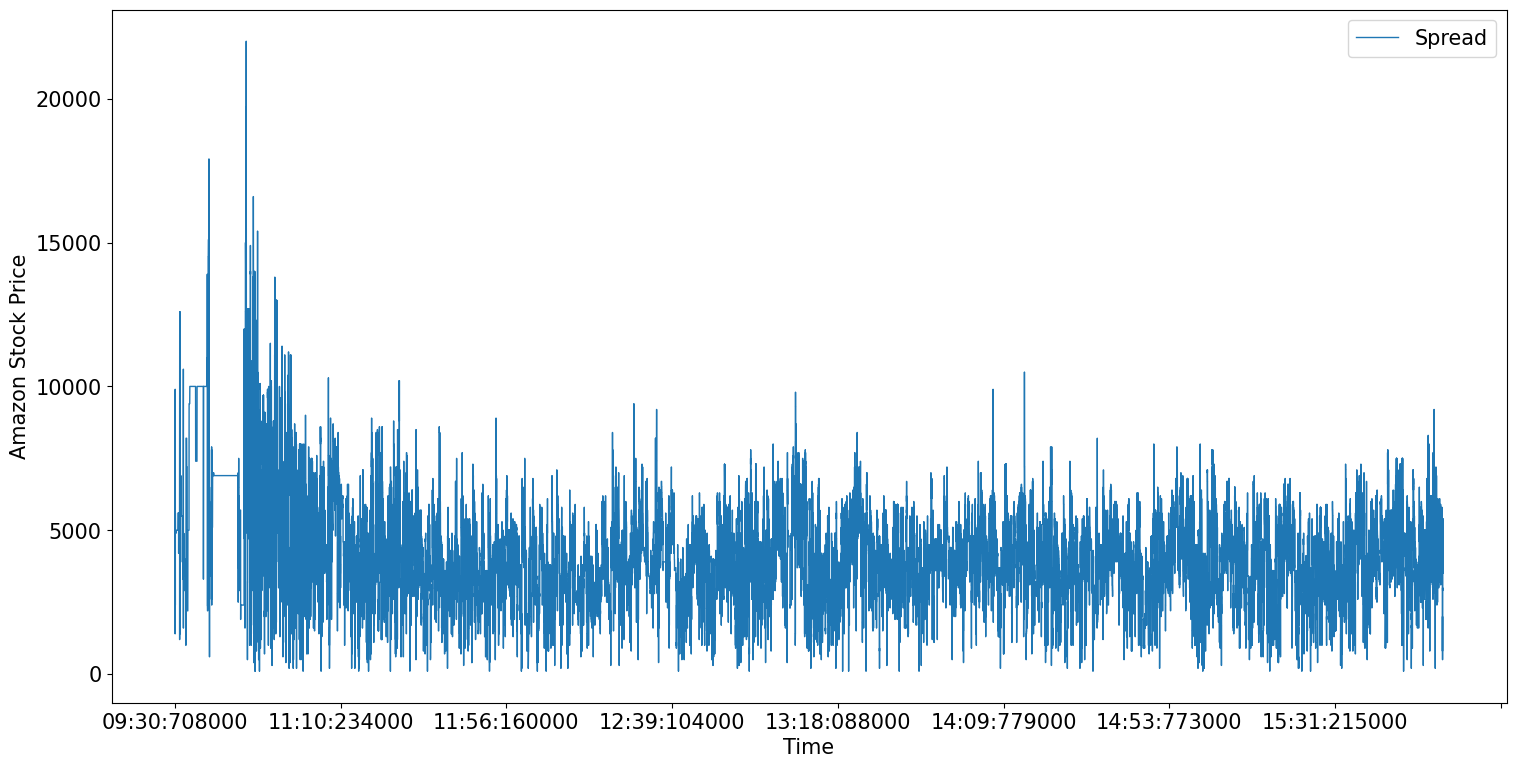

In [9]:
# Plot Spread

df_filtered.plot(x="Time", y=["Spread"],
                       figsize=(18, 9), linewidth=1.0, fontsize=15)

plt.legend(loc=1, prop={'size': 15})
plt.rcParams.update({'font.size': 15})
plt.ylabel('Amazon Stock Price',fontsize=15);

## 4. Feature Selection

- Based on Variance Threshold
- Based on Correlation

In [10]:
Feature_Matrix = df.iloc[:,3:]

# 1. Variance Threshold - Adjsut it to the LOB dataset
from sklearn.feature_selection import VarianceThreshold

thresholder = VarianceThreshold(threshold=0.5)
features_high_variance = thresholder.fit_transform(Feature_Matrix)
mask = thresholder.get_support()

dropped_columns = Feature_Matrix.columns[~mask]
print("\nDropped Columns:", dropped_columns)


# 2. Correlation-based Method
dataframe = pd.DataFrame(Feature_Matrix)

corr_matrix = dataframe.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
print('to_drop ->', to_drop)


Dropped Columns: Index([], dtype='object')
to_drop -> ['BidPrice1', 'AskPrice2', 'BidPrice2', 'AskPrice3', 'BidPrice3', 'AskPrice4', 'BidPrice4', 'AskPrice5', 'BidPrice5', 'AskPrice6', 'BidPrice6', 'BidPrice7', 'BidPrice9', 'BidPrice10']


## 5. Feature Engineering

3 new handcrafted features added

In [11]:
# Lagged Features
df['Ask_lag_1'] = df['AskPrice1'].shift(1)
df['Bid_lag_1'] = df['BidPrice1'].shift(1)

# Rolling Window
df['rolling_ask'] = df['AskPrice1'].rolling(window=4).mean()
df['rolling_bid'] = df['BidPrice1'].rolling(window=4).mean()

#Log return
df['log_returns'] = np.log(df['Mid_Price']).diff()

In [12]:
df.describe()

,Mid_Price,Spread,AskPrice1,AskVolume1,BidPrice1,BidVolume1,AskPrice2,AskVolume2,BidPrice2,BidVolume2,...,BidVolume9,AskPrice10,AskVolume10,BidPrice10,BidVolume10,Ask_lag_1,Bid_lag_1,rolling_ask,rolling_bid,log_returns
count,4.774380e+05,477438.000000,4.774380e+05,477438.000000,4.774380e+05,477438.000000,4.774380e+05,477438.000000,4.774380e+05,477438.000000,...,477438.000000,4.774380e+05,477438.000000,4.774380e+05,477438.000000,4.774370e+05,4.774370e+05,4.774350e+05,4.774350e+05,4.774370e+05
mean,5.364946e+06,4056.941006,5.366974e+06,159.687800,5.362917e+06,119.957023,5.367795e+06,149.405818,5.362334e+06,104.043844,...,139.376887,5.438465e+06,130.043195,5.358350e+06,139.761843,5.366974e+06,5.362917e+06,5.366974e+06,5.362917e+06,-1.456082e-08
std,2.132777e+04,1812.814462,2.168483e+04,219.328436,2.100379e+04,139.811515,2.200259e+04,373.254170,2.084221e+04,120.277754,...,161.203100,1.118008e+07,135.393197,2.035878e+04,152.321806,2.168483e+04,2.100381e+04,2.168255e+04,2.100301e+04,4.957961e-05
min,5.327900e+06,100.000000,5.329500e+06,1.000000,5.326100e+06,1.000000,5.330300e+06,1.000000,5.326000e+06,1.000000,...,1.000000,5.333400e+06,1.000000,5.000000e+06,1.000000,5.329500e+06,5.326100e+06,5.329500e+06,5.326100e+06,-2.477600e-03
25%,5.349050e+06,3000.000000,5.351000e+06,99.000000,5.347100e+06,64.000000,5.351900e+06,40.000000,5.346500e+06,40.000000,...,60.000000,5.355500e+06,100.000000,5.343700e+06,70.000000,5.351000e+06,5.347100e+06,5.351000e+06,5.347050e+06,0.000000e+00
50%,5.360550e+06,3800.000000,5.362500e+06,100.000000,5.358600e+06,100.000000,5.363200e+06,100.000000,5.358000e+06,100.000000,...,100.000000,5.367100e+06,100.000000,5.354900e+06,100.000000,5.362500e+06,5.358600e+06,5.362500e+06,5.358600e+06,0.000000e+00
75%,5.376550e+06,4900.000000,5.378500e+06,199.000000,5.374700e+06,131.000000,5.379100e+06,100.000000,5.374300e+06,100.000000,...,200.000000,5.382500e+06,100.000000,5.369600e+06,200.000000,5.378500e+06,5.374700e+06,5.378500e+06,5.374700e+06,0.000000e+00
max,5.434750e+06,29000.000000,5.437900e+06,5050.000000,5.431600e+06,5100.000000,5.449900e+06,5050.000000,5.431500e+06,5100.000000,...,5232.000000,2.000000e+09,4400.000000,5.426600e+06,5232.000000,5.437900e+06,5.431600e+06,5.437900e+06,5.431600e+06,2.477600e-03


## 6. Prepare Train & Test data

In [13]:
# Identify the Columns that will be utilized as Inputs to the Regressors
Feature_Matrix = df.iloc[4:-1,3:] 
Mid_Price_Series = df['Mid_Price'].iloc[4:]

# Extarct Targets/Labels
Forecasting_Variable = Mid_Price_Series

print('Mid_Price_Series length:',len(Mid_Price_Series))
print('Feature_Matrix length:', len(Feature_Matrix))

Mid_Price_Series length: 477434
Feature_Matrix length: 477433


## 7. Training Models

- Convolutional Neural Network (CNN) - Forecasting
- Convolutional Neural Network - Autoencoder
- Radial Basic Function Neural Network (RBFNN)
- Multilayer Perceptron
- Long Short-Term Memory
- Random Forest
- Gradient Boosting
- Bayesian Regression
- ARIMA

#### CNN Forecasting

In [14]:
#CNN Forecasting

warnings.filterwarnings("ignore")

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
Feature_Matrix_Scaled = pd.DataFrame(scaler_x.fit_transform(Feature_Matrix), columns=Feature_Matrix.columns)
Forecasting_Variable_Scaled = pd.Series(scaler_y.fit_transform(Forecasting_Variable.values.reshape(-1, 1)).flatten())

tscv = TimeSeriesSplit()
print(tscv)
print(62*'#')

test_scores = {'RMSE': [], 'MPE': []}
for train_index, test_index in tscv.split(Feature_Matrix_Scaled):
    print('-' * 62)
    X_train, X_test = Feature_Matrix_Scaled.iloc[train_index], Feature_Matrix_Scaled.iloc[test_index]
    Y_train, Y_test = Forecasting_Variable_Scaled.iloc[train_index], Forecasting_Variable_Scaled.iloc[test_index]


    #Train set
    look_back = 10
    X_train_numpy = np.array([X_train.iloc[i:i+look_back, :].values for i in range(len(X_train)-look_back)])
    Y_train_numpy = np.array([Y_train.iloc[i+look_back] for i in range(len(Y_train)-look_back)])

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back, X_train_numpy.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear')) 
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])

    model.fit(X_train_numpy, Y_train_numpy, epochs=2, batch_size=40000, verbose=2)

    #Test set
    look_back = 10
    X_test_numpy = np.array([X_test.iloc[i:i+look_back, :].values for i in range(len(X_test)-look_back)])
    Y_test_numpy = np.array([Y_test.iloc[i+look_back] for i in range(len(Y_test)-look_back)]).reshape(-1, 1)

    Yt = model.predict(X_test_numpy)

    Yt_inverse = scaler_y.inverse_transform(Yt)
    Y_test_numpy_inverse = scaler_y.inverse_transform(Y_test_numpy)

    rmse = np.sqrt(mean_squared_error(Y_test_numpy_inverse, Yt_inverse))
    mpe = np.mean((Y_test_numpy_inverse - Yt_inverse) / Y_test_numpy_inverse) * 100

    test_scores['RMSE'].append(rmse)
    test_scores['MPE'].append(mpe)

    print('RMSE:', rmse)
    print('MPE:', mpe)
    print(62*'#')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
##############################################################
--------------------------------------------------------------
Epoch 1/2


2024-04-16 12:44:27.272814: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 - 1s - loss: 0.0893 - mse: 0.0893 - 635ms/epoch - 318ms/step
Epoch 2/2
2/2 - 0s - loss: 0.0544 - mse: 0.0544 - 392ms/epoch - 196ms/step
2487/2487 [==============================] - 1s 457us/step
RMSE: 12971.095132163357
MPE: -0.24056600321294228
##############################################################
--------------------------------------------------------------
Epoch 1/2
4/4 - 1s - loss: 0.0341 - mse: 0.0341 - 1s/epoch - 310ms/step
Epoch 2/2
4/4 - 1s - loss: 0.0114 - mse: 0.0114 - 799ms/epoch - 200ms/step
2487/2487 [==============================] - 1s 465us/step
RMSE: 3794.971400065841
MPE: -0.066634600099354
##############################################################
--------------------------------------------------------------
Epoch 1/2
6/6 - 2s - loss: 0.0260 - mse: 0.0260 - 2s/epoch - 253ms/step
Epoch 2/2
6/6 - 1s - loss: 0.0067 - mse: 0.0067 - 1s/epoch - 198ms/step
2487/2487 [==============================] - 1s 452us/step
RMSE: 5707.320301337972
MPE: -0.103162775

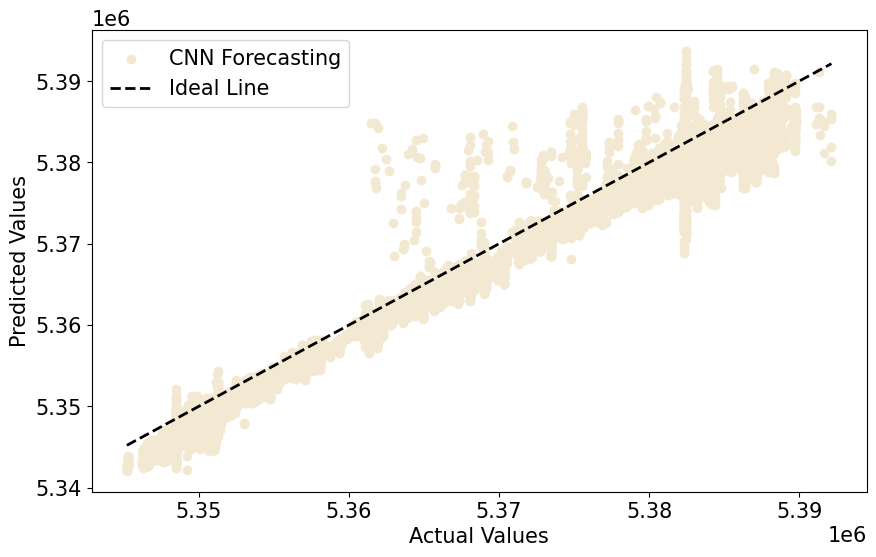

In [15]:
# Plot predicted vs actual values for CNN Forecasting model
plt.figure(figsize=(10, 6))
plt.scatter(Y_test_numpy_inverse, Yt_inverse, color='#F3E9D2', label='CNN Forecasting')
plt.plot([Y_test_numpy_inverse.min(), Y_test_numpy_inverse.max()], [Y_test_numpy_inverse.min(), Y_test_numpy_inverse.max()], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


#### CNN Autoencoder

In [16]:
#CNN Autoencoder

tscv = TimeSeriesSplit()
print(tscv)
print(62*'#')

counter = 0
for train_index, test_index in tscv.split(Feature_Matrix):
    counter += 1
    print('Fold %d:' %counter)
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    X_train, X_test = Feature_Matrix.iloc[train_index,:], Feature_Matrix.iloc[test_index,:]
    Y_train, Y_test = Forecasting_Variable.iloc[train_index], Forecasting_Variable.iloc[test_index]
    print(62*'-')
   
    X_train_to_Numpy = pd.DataFrame(X_train).to_numpy()
    Y_train_to_Numpy = pd.DataFrame(Y_train).to_numpy()

    look_back = 10
    x_train_append_matrix = []
    y_train_append_matrix = []

    for i in range(len(X_train)-look_back):         
        feat_current_train = X_train_to_Numpy[i:i+look_back, :]
        label_current_train = Y_train_to_Numpy[i+look_back]
        x_train_append_matrix.append(feat_current_train)
        y_train_append_matrix.append(label_current_train)
    
    X_train_numpy = np.array(x_train_append_matrix)
    Y_train_numpy = np.array(y_train_append_matrix)
    
    
   # define the input shape
    input_shape = (look_back, X_train_numpy.shape[2])
    
    # define the model architecture
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(16, 3, activation='relu', padding='same')(x)
    encoded = MaxPooling1D(2, padding='same')(x)
    
    x = Conv1D(16, 3, activation='relu', padding='same')(encoded)
    x = UpSampling1D(2)(x)
    x = Conv1D(32, 3, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    decoded = Conv1D(1, 3, activation='linear', padding='same')(x)
    
    # create the model
    model = keras.Model(inputs, decoded)
    
    # compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    model.fit(X_train_numpy, Y_train_numpy, epochs=1, batch_size=32)
    
    # extract the trained features
    encoder = Model(inputs, encoded)
    encoded_data = encoder.predict(X_train_numpy)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
##############################################################
Fold 1:
TRAIN: 79573 TEST: 79572
--------------------------------------------------------------
2487/2487 [==============================] - 1s 367us/step
Fold 2:
TRAIN: 159145 TEST: 79572
--------------------------------------------------------------
4973/4973 [==============================] - 2s 370us/step
Fold 3:
TRAIN: 238717 TEST: 79572
--------------------------------------------------------------
7460/7460 [==============================] - 3s 369us/step
Fold 4:
TRAIN: 318289 TEST: 79572
--------------------------------------------------------------
9947/9947 [==============================] - 4s 372us/step
Fold 5:
TRAIN: 397861 TEST: 79572
--------------------------------------------------------------
12433/12433 [==============================] - 5s 372us/step


#### Radial Basis Function Neural Network

In [17]:
#RBFNN

test_scores = {'RMSE': [], 'MPE': []}
counter = 0

tscv = TimeSeriesSplit()
print(tscv)
print(62*'#')

for train_index, test_index in tscv.split(Feature_Matrix):
    counter += 1
    print('Fold %d:' % counter)
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

    X_train, X_test = Feature_Matrix.iloc[train_index], Feature_Matrix.iloc[test_index]
    y_train, y_test = Forecasting_Variable.iloc[train_index], Forecasting_Variable.iloc[test_index]

    # Apply MinMax normalization 
    X_train_normalized = scaler_x.fit_transform(X_train)
    X_test_normalized = scaler_x.transform(X_test)

    y_train_normalized = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    # Define the pipeline
    pipeline = make_pipeline(
        KMeans(n_clusters=10, random_state=0),
        RBFSampler(gamma=1.0 / (2 * len(X_train_normalized)), n_components=10, random_state=0),
        Ridge(alpha=1.0)
    )

    pipeline.fit(X_train_normalized, y_train_normalized)

    y_pred_normalized = pipeline.predict(X_test_normalized)
    y_pred = scaler_y.inverse_transform(y_pred_normalized.reshape(-1, 1)).flatten()

    mse = mean_squared_error(y_test, y_pred)
    test_scores['RMSE'].append(np.sqrt(mse))
    test_scores['MPE'].append(np.mean((y_pred - y_test) / np.where(y_test == 0, 1, y_test)))

    print('RMSE:', np.sqrt(mse))
    print('MPE:', np.mean((y_pred - y_test) / y_test))
    print(62*'#')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
##############################################################
Fold 1:
TRAIN: 79573 TEST: 79572
RMSE: 20679.228996752183
MPE: 0.0037265981727797838
##############################################################
Fold 2:
TRAIN: 159145 TEST: 79572
RMSE: 6902.885474831799
MPE: 0.0007942834315379885
##############################################################
Fold 3:
TRAIN: 238717 TEST: 79572
RMSE: 4214.737261442079
MPE: 0.0006426238807093002
##############################################################
Fold 4:
TRAIN: 318289 TEST: 79572
RMSE: 13814.01670500611
MPE: 0.00220290877462538
##############################################################
Fold 5:
TRAIN: 397861 TEST: 79572
RMSE: 2999.8913984958663
MPE: 0.000396949669924814
##############################################################


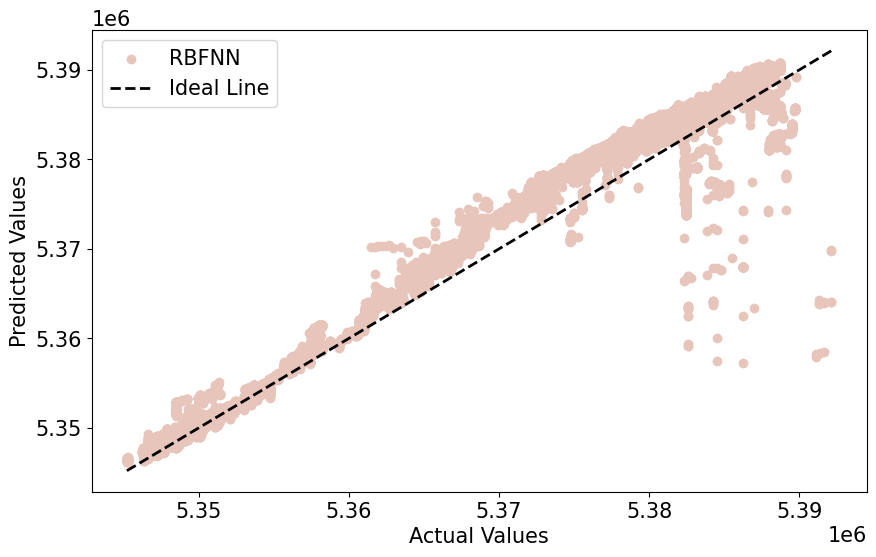

In [18]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='#E8C5BB', label='RBFNN')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

#### Multilayer Perceptron

In [19]:
#MLP

test_scores = {'RMSE': [], 'MPE': []}

tscv = TimeSeriesSplit()
print(tscv)
print(62*'#')

counter = 0
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()
for train_index, test_index in tscv.split(Feature_Matrix):
    counter += 1
    print('Fold %d:' % counter)
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    # Split data into training and testing sets
    X_train, X_test = Feature_Matrix.iloc[train_index,:], Feature_Matrix.iloc[test_index,:]
    y_train, y_test = Forecasting_Variable.iloc[train_index], Forecasting_Variable.iloc[test_index]

    X_train_normalized = scaler_features.fit_transform(X_train)
    X_test_normalized = scaler_features.transform(X_test)
    y_train_normalized = scaler_target.fit_transform(y_train.values.reshape(-1, 1)).flatten()

    print(62*'-')

    ## ----------------------------------------------------------------------------------------- ##
    # Shallow MLP
    print('Shallow MLP')
    model_mlp = Sequential()
    model_mlp.add(Dense(100, activation='relu', input_dim=X_train_normalized.shape[1]))
    model_mlp.add(Dense(1))
    model_mlp.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model_mlp.summary()
    history = model_mlp.fit(X_train_normalized, y_train_normalized, epochs=5, batch_size=10000, verbose=0)

    # Predict on the test set
    y_mlp1_normalized = model_mlp.predict(X_test_normalized)
    
    y_mlp1 = scaler_target.inverse_transform(y_mlp1_normalized.reshape(-1, 1)).flatten()
    y_true = y_test
    
    # Calculate RMSE and MPE
    rmse = np.sqrt(mean_squared_error(y_true, y_mlp1))
    mpe = np.mean((y_mlp1 - y_true) / np.where(y_true == 0, 1, y_true)) * 100
    
    test_scores['RMSE'].append(rmse)
    test_scores['MPE'].append(mpe)
    
    print('RMSE (Shallow MLP):', rmse)
    print('MPE (Shallow MLP):', mpe)
    print(62*'#')

    ## ----------------------------------------------------------------------------------------- ##
    # Deep MLP
    print('Deep MLP')
    model_mlp = Sequential()
    model_mlp.add(Dense(100, activation='relu', input_dim=X_train_normalized.shape[1]))
    model_mlp.add(Dense(32, activation='relu'))
    model_mlp.add(Dense(1))
    model_mlp.compile(loss='mse', optimizer='adam', metrics=['mse'])
    history = model_mlp.fit(X_train_normalized, y_train_normalized, epochs=5, batch_size=10000, verbose=0)

    # Predict on the test set
    y_mlp2_normalized = model_mlp.predict(X_test_normalized)
    y_mlp2 = scaler_target.inverse_transform(y_mlp2_normalized.reshape(-1, 1)).flatten()
    
    # Calculate RMSE and MPE
    rmse = np.sqrt(mean_squared_error(y_true, y_mlp2))
    mpe = np.mean((y_mlp2 - y_true) / np.where(y_true == 0, 1, y_true)) * 100
    
    test_scores['RMSE'].append(rmse)
    test_scores['MPE'].append(mpe)
    
    print('RMSE (Deep MLP):', rmse)
    print('MPE (Deep MLP):', mpe)
    print(62*'#')

 ## ----------------------------------------------------------------------------------------- ##
    # Very Deep MLP
    print('Very Deep MLP')
    model_mlp = Sequential()
    model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
    model_mlp.add(Dense(100, activation='relu'))
    model_mlp.add(Dense(100, activation='relu'))
    model_mlp.add(Dense(32, activation='relu'))
    model_mlp.add(Dense(1))
    model_mlp.compile(loss='mse', optimizer='adam', metrics=['mse'])
    history = model_mlp.fit(X_train_normalized, y_train_normalized, epochs=5, batch_size=10000, verbose=0)

    # Predict on the test set
    y_mlp3_normalized = model_mlp.predict(X_test_normalized)
    y_mlp3 = scaler_target.inverse_transform(y_mlp3_normalized.reshape(-1, 1)).flatten()
    
    # Calculate RMSE and MPE
    rmse = np.sqrt(mean_squared_error(y_true, y_mlp3))
    mpe = np.mean((y_mlp3 - y_true) / np.where(y_true == 0, 1, y_true)) * 100
    
    test_scores['RMSE'].append(rmse)
    test_scores['MPE'].append(mpe)
    
    print('RMSE (Very Deep MLP):', rmse)
    print('MPE (Very Deep MLP):', mpe)
    print(62*'#')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
##############################################################
Fold 1:
TRAIN: 79573 TEST: 79572
--------------------------------------------------------------
Shallow MLP
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               4600      
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 4,701
Trainable params: 4,701
Non-trainable params: 0
_________________________________________________________________
2487/2487 [==============================] - 1s 264us/step
RMSE (Shallow MLP): 5571.702888060985
MPE (Shallow MLP): 0.06298483916411055
##############################################################
Deep M

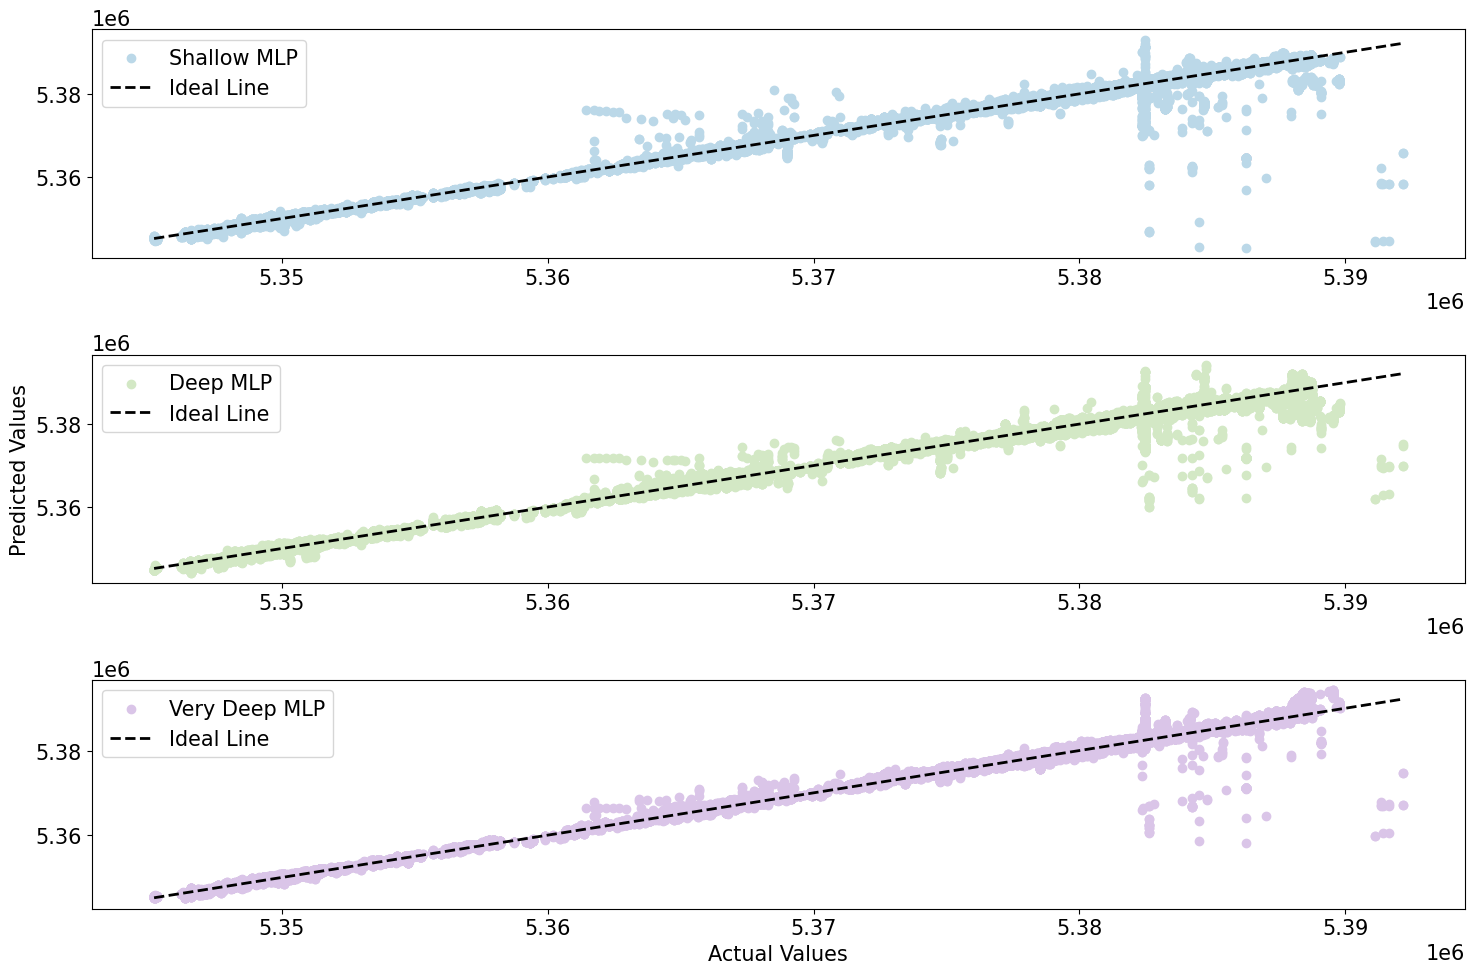

In [20]:
plt.figure(figsize=(15, 10))

# Shallow MLP
plt.subplot(3, 1, 1)
plt.scatter(y_true, y_mlp1, color='#BBD8E8', label='Shallow MLP')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Ideal Line')
plt.legend()

# Deep MLP
plt.subplot(3, 1, 2)
plt.scatter(y_true, y_mlp2, color='#D3E8C5', label='Deep MLP')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Ideal Line')
plt.ylabel('Predicted Values')
plt.legend()

# Very Deep MLP
plt.subplot(3, 1, 3)
plt.scatter(y_true, y_mlp3, color='#DAC5E8', label='Very Deep MLP')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.legend()

plt.tight_layout()
plt.show()


#### Long Short-Term Memory

In [21]:
#LSTM

tscv = TimeSeriesSplit()
print(tscv)
print(62*'#')

test_scores = {'RMSE': [], 'MPE': []}
counter = 0

for train_index, test_index in tscv.split(Feature_Matrix):
    counter += 1
    print('Fold %d:' % counter)
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    
    X_train, X_test = Feature_Matrix.iloc[train_index, :], Feature_Matrix.iloc[test_index, :]
    Y_train, Y_test = Forecasting_Variable.iloc[train_index], Forecasting_Variable.iloc[test_index]
    print(62*'-')
    
    X_train_normalized = scaler_x.fit_transform(X_train)
    X_test_normalized = scaler_x.transform(X_test)
    Y_train_normalized = scaler_y.fit_transform(Y_train.values.reshape(-1, 1)).flatten()

    # Prepare LSTM data - 3D Inputs of the format [samples, lookback period, features]
    look_back = 10
    X_train_lstm, Y_train_lstm = [], []
    for i in range(len(X_train_normalized) - look_back):
        X_train_lstm.append(X_train_normalized[i:i + look_back, :])
        Y_train_lstm.append(Y_train_normalized[i + look_back])

    X_train_lstm, Y_train_lstm = np.array(X_train_lstm), np.array(Y_train_lstm)

    # Build LSTM
    def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

    model = Sequential()
    model.add(LSTM(256, input_shape=(look_back, X_train_normalized.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Fit the model with history to check for overfitting
    history = model.fit(X_train_lstm, Y_train_lstm, epochs=1, batch_size=40000, validation_split=0.2, shuffle=False)
    
    X_test_lstm, Y_test_lstm = [], []
    for i in range(len(X_test_normalized) - look_back):
        X_test_lstm.append(X_test_normalized[i:i + look_back, :])
        Y_test_lstm.append(Y_test.values[i + look_back])

    X_test_lstm, Y_test_lstm = np.array(X_test_lstm), np.array(Y_test_lstm)

    # Predict on the test set
    Yt = model.predict(X_test_lstm)

    Yt_inverse = scaler_y.inverse_transform(Yt.reshape(-1, 1)).flatten()
    Y_test_inverse = Y_test.values[look_back:]

    rmse = np.sqrt(mean_squared_error(Y_test_inverse, Yt_inverse))
    mpe = np.mean((Yt_inverse - Y_test_inverse) / np.where(Y_test_inverse == 0, 1, Y_test_inverse)) * 100

    test_scores['RMSE'].append(rmse)
    test_scores['MPE'].append(mpe)

    print('RMSE:', rmse)
    print('MPE:', mpe)
    print(62*'#')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
##############################################################
Fold 1:
TRAIN: 79573 TEST: 79572
--------------------------------------------------------------
2487/2487 [==============================] - 8s 3ms/step
RMSE: 15500.243836266282
MPE: 0.2873252751417756
##############################################################
Fold 2:
TRAIN: 159145 TEST: 79572
--------------------------------------------------------------
2487/2487 [==============================] - 423s 170ms/step
RMSE: 34580.001989456556
MPE: 0.6276592219464359
##############################################################
Fold 3:
TRAIN: 238717 TEST: 79572
--------------------------------------------------------------
2487/2487 [==============================] - 8s 3ms/step
RMSE: 21698.072896270332
MPE: 0.38727957087490794
##############################################################
Fold 4:
TRAIN: 318289 TEST: 79572
-----------------------------

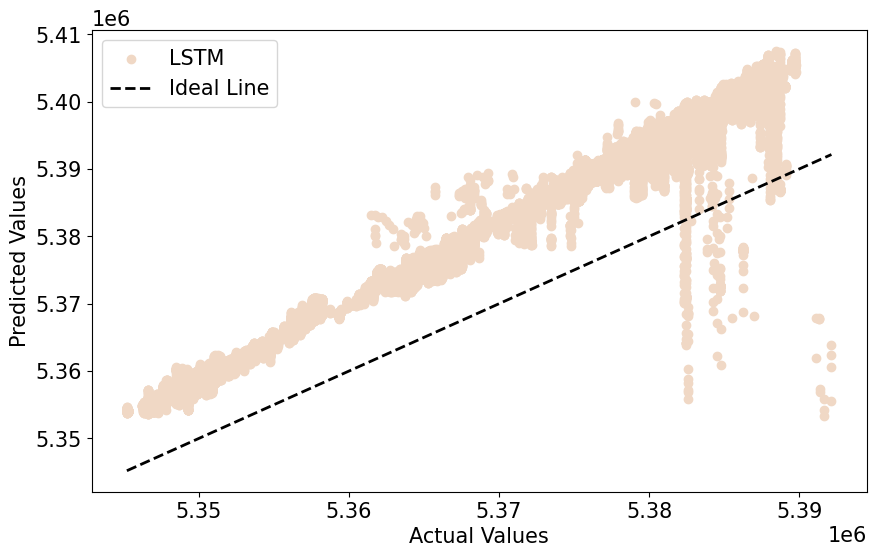

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_test_inverse, Yt_inverse, color='#F0D8C5', label='LSTM')
plt.plot([Y_test_inverse.min(), Y_test_inverse.max()], [Y_test_inverse.min(), Y_test_inverse.max()], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

#### Random Forest, Gradient Boosting, Bayesian Regression, ARIMA

In [23]:
# Other Regressors

warnings.filterwarnings("ignore")

# Define look back period
look_back = 10

# Initialize lists to store test scores
test_scores = {'Random Forest': {'RMSE': [], 'MPE': []},
               'Gradient Boosting': {'RMSE': [], 'MPE': []},
               'Bayesian Regression': {'RMSE': [], 'MPE': []},
               'ARIMA': {'RMSE': [], 'MPE': []}}

scaler_x = MinMaxScaler()

# Time series K-Fold Cross Validation
counter = 0
for train_index, test_index in tscv.split(Feature_Matrix):
    counter += 1
    print('Fold %d:' % counter)
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    print(62 * '-')

    # Train-test split for features and target
    X_train, X_test = Feature_Matrix.iloc[train_index, :], Feature_Matrix.iloc[test_index, :]
    Y_train, Y_test = Forecasting_Variable.iloc[train_index], Forecasting_Variable.iloc[test_index]
    
    # Apply MinMax normalization to features
    X_train_rf_gb_normalized = scaler_x.fit_transform(X_train)
    X_test_rf_gb_normalized = scaler_x.transform(X_test)

    # Train Random Forest model
    model_rf = RandomForestRegressor()
    model_rf.fit(X_train_rf_gb_normalized, Y_train)

    # Train Gradient Boosting model
    model_gb = GradientBoostingRegressor()
    model_gb.fit(X_train_rf_gb_normalized, Y_train)

    # Train Bayesian Regression model
    model_bayesian = BayesianRidge()
    model_bayesian.fit(X_train, Y_train)

    # Train ARIMA model
    model_arima = ARIMA(Y_train, order=(5, 1, 0))
    model_arima_fit = model_arima.fit()

    def mean_percentage_error(y_true, y_pred):
        return np.mean((y_true - y_pred) / y_true) * 100

    # Predict using Random Forest
    Y_pred_rf = model_rf.predict(X_test_rf_gb_normalized)
    rmse_rf = np.sqrt(mean_squared_error(Y_test, Y_pred_rf))
    mpe_rf = np.mean((Y_test - Y_pred_rf) / Y_test) * 100
    test_scores['Random Forest']['RMSE'].append(rmse_rf)
    test_scores['Random Forest']['MPE'].append(mpe_rf)
    print('Random Forest Test Score (RMSE):', rmse_rf)
    print('Random Forest Test Score (MPE):', mpe_rf)

    # Predict using Gradient Boosting
    Y_pred_gb = model_gb.predict(X_test_rf_gb_normalized)
    rmse_gb = np.sqrt(mean_squared_error(Y_test, Y_pred_gb))
    mpe_gb = np.mean((Y_test - Y_pred_gb) / Y_test) * 100
    test_scores['Gradient Boosting']['RMSE'].append(rmse_gb)
    test_scores['Gradient Boosting']['MPE'].append(mpe_gb)
    print('Gradient Boosting Test Score (RMSE):', rmse_gb)
    print('Gradient Boosting Test Score (MPE):', mpe_gb)

    # Predict using Bayesian Regression
    Y_pred_bayesian = model_bayesian.predict(X_test)
    rmse_bayesian = np.sqrt(mean_squared_error(Y_test, Y_pred_bayesian))
    mpe_bayesian = np.mean((Y_test - Y_pred_bayesian) / Y_test) * 100
    test_scores['Bayesian Regression']['RMSE'].append(rmse_bayesian)
    test_scores['Bayesian Regression']['MPE'].append(mpe_bayesian)
    print('Bayesian Regression Test Score (RMSE):', rmse_bayesian)
    print('Bayesian Regression Test Score (MPE):', mpe_bayesian)

    # Predict using ARIMA
    Y_pred_arima = model_arima_fit.forecast(steps=len(X_test))
    rmse_arima = np.sqrt(mean_squared_error(Y_test, Y_pred_arima))
    mpe_arima = np.mean((Y_test - Y_pred_arima) / Y_test) * 100
    test_scores['ARIMA']['RMSE'].append(rmse_arima)
    test_scores['ARIMA']['MPE'].append(mpe_arima)
    print('ARIMA Test Score (RMSE):', rmse_arima)
    print('ARIMA Test Score (MPE):', mpe_arima)
    print(62 * '#')


Fold 1:
TRAIN: 79573 TEST: 79572
--------------------------------------------------------------
Random Forest Test Score (RMSE): 13066.768823748507
Random Forest Test Score (MPE): -0.1922800025127108
Gradient Boosting Test Score (RMSE): 13300.396381113582
Gradient Boosting Test Score (MPE): -0.19728869435132768
Bayesian Regression Test Score (RMSE): 0.001024248369027722
Bayesian Regression Test Score (MPE): 1.6196980187416457e-10
ARIMA Test Score (RMSE): 15988.367323730405
ARIMA Test Score (MPE): nan
##############################################################
Fold 2:
TRAIN: 159145 TEST: 79572
--------------------------------------------------------------
Random Forest Test Score (RMSE): 238.0551795652015
Random Forest Test Score (MPE): 0.00029546073910885576
Gradient Boosting Test Score (RMSE): 333.5449130831716
Gradient Boosting Test Score (MPE): -0.000129001676401066
Bayesian Regression Test Score (RMSE): 0.006893525207147121
Bayesian Regression Test Score (MPE): -3.76787152122758

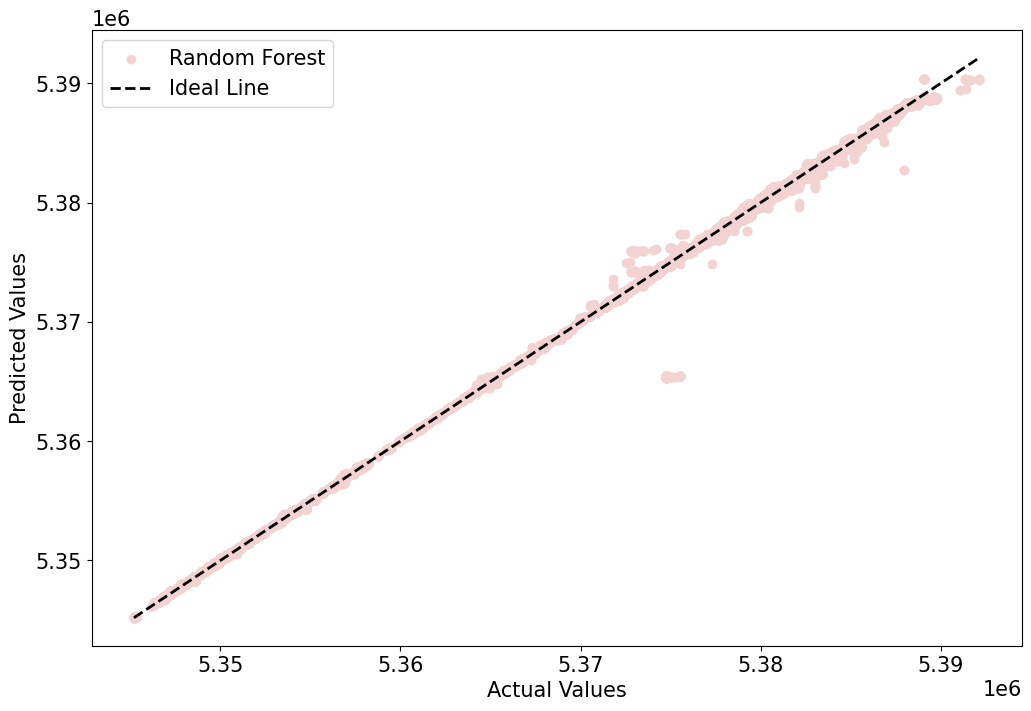

In [24]:
plt.figure(figsize=(12, 8))
plt.scatter(Y_test, Y_pred_rf, color='#F3D2D2', label='Random Forest')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

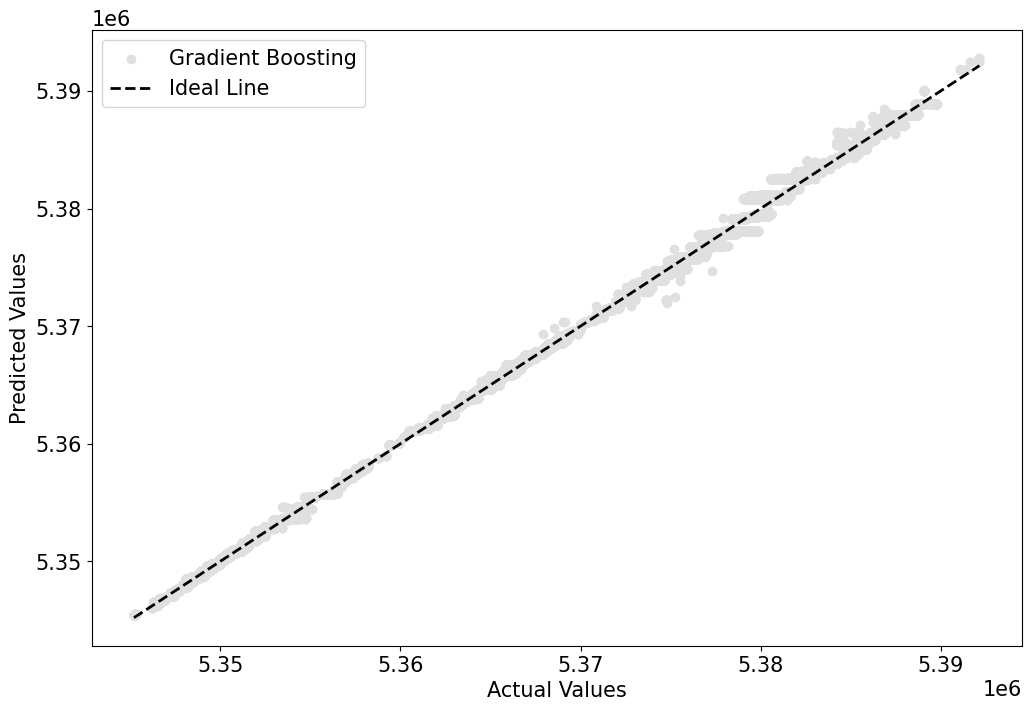

In [25]:
plt.figure(figsize=(12, 8))
plt.scatter(Y_test, Y_pred_gb, color='#E0E0E0', label='Gradient Boosting')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


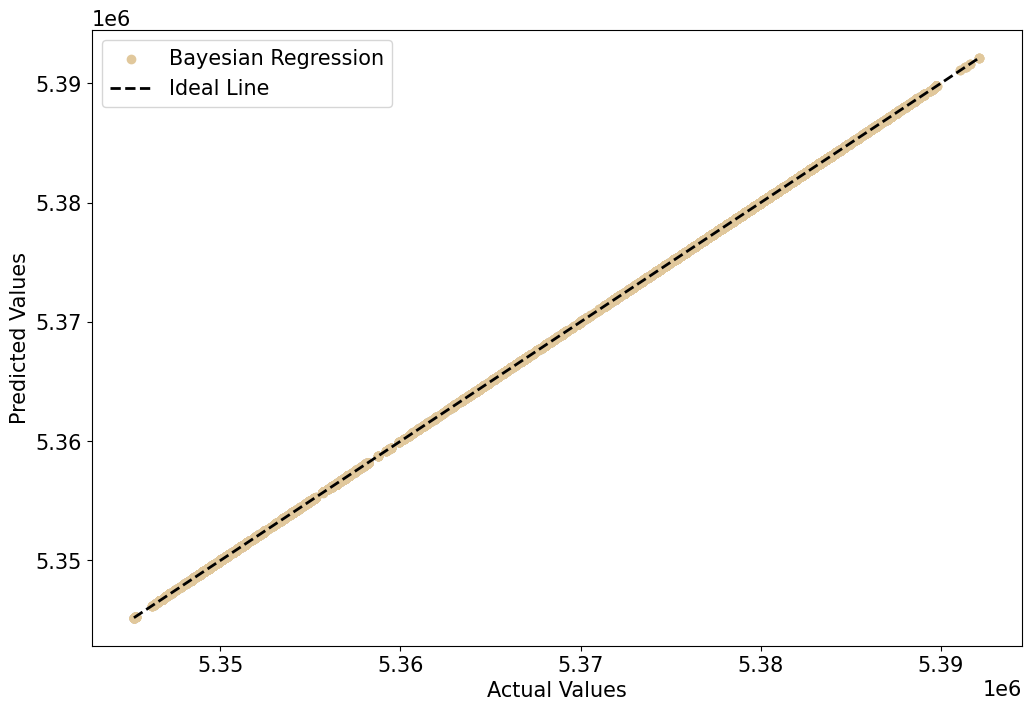

In [26]:
plt.figure(figsize=(12, 8))
plt.scatter(Y_test, Y_pred_bayesian, color='#E1C89C', label='Bayesian Regression')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

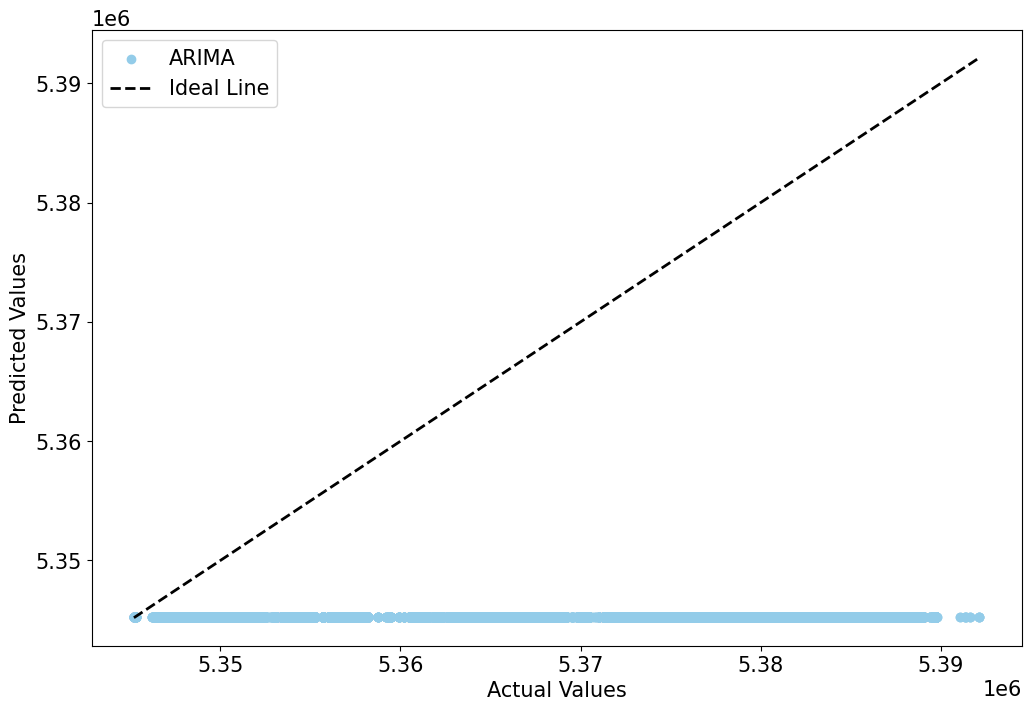

In [27]:
plt.figure(figsize=(12, 8))
plt.scatter(Y_test, Y_pred_arima, color='#93CCE9', label='ARIMA')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2, label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()